# Notebook to convert disk field functions for array use

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### General constants

In [2]:
kPi = np.pi
kTwoPi = 2 * kPi
degree = kPi / 180.
kpc = 1
microgauss = 1
megayear = 1
Gpc = 1e6 * kpc
pc = 1e-3 * kpc
second = megayear / (1e6 * 60 * 60 * 24 * 365.25)
kilometer = kpc / 3.0856775807e+16

### General functions

In [3]:
def sigmoid(x, x0, w):
    """
    Calculates the logistic sigmoid function.
    Arguments:
    x : float
        The input value
    x0 : float
        The midpoint of the sigmoid
    w : float
        The width of the sigmoid
    
    Returns:
    The result of the sigmoid function
    """
    return 1 / (1 + np.exp(-(x - x0) / w))

def delta_phi(phi0, phi1):
    """
    Calculates the angle between v0 = (cos(phi0), sin(phi0)) and v1 = (cos(phi1), sin(phi1)).
    Arguments:
    phi0 : float
        First angle in radians
    phi1 : float
        Second angle in radians
    
    Returns:
    The angle between v0 and v1 in radians.
    """
    return np.arccos(np.cos(phi1) * np.cos(phi0) + np.sin(phi1) * np.sin(phi0))

def signum(x):
    """Return the sign of each entry of an array"""
    return (x < 0.) * -1. + (x >= 0) * 1.

# Fourier-Spiral disk field

Parameters for neCl model

In [4]:
fDiskB1        =  1.4259645e+00 * microgauss
fDiskB2        =  1.3543223e+00 * microgauss
fDiskB3        =  3.4390669e+00 * microgauss
fDiskH         =  6.7405199e-01 * kpc
fDiskPhase1    =  1.9961898e+02 * degree
fDiskPhase2    =  1.3541461e+02 * degree
fDiskPhase3    =  6.4909767e+01 * degree
fDiskPitch     =  1.1867859e+01 * degree
fDiskW         =  6.1162799e-02 * kpc
fPoloidalB     =  9.8387831e-01 * microgauss
fPoloidalP     =  1.6773615e+00 * kpc
fPoloidalR     =  7.4084361e+00 * kpc
fPoloidalW     =  1.4168192e-01 * kpc
fPoloidalZ     =  3.6521188e+00 * kpc
fStriation     =  3.3600213e-01
fToroidalBN    =  2.6256593e+00 * microgauss
fToroidalBS    = -2.5699466e+00 * microgauss
fToroidalR     =  1.0134257e+01 * kpc
fToroidalW     =  1.1547728e+00 * kpc
fToroidalZ     =  4.5585463e+00 * kpc

    
fSinPitch = np.sin(fDiskPitch)
fCosPitch = np.cos(fDiskPitch)
fTanPitch = np.tan(fDiskPitch)

In [5]:
def get_spiral_field_cyl(rho, phi, z):

    if (not rho.shape[0] == phi.shape[0]) or (not z.shape[0] == phi.shape[0]):
        raise ValueError("List do not have equal shape!")

    # reference radius
    r_ref = 5 * kpc
    # inner boundary of spiral field, w = transition width
    r_inner = 5 * kpc
    w_inner = 0.5 * kpc
    # outer boundary of spiral field
    r_outer = 20 * kpc
    w_outer = 0.5 * kpc
    
    # Avoid division by zero
    rho_safe = np.where(rho == 0, 1e-12 * kpc, rho)
    
    # Eq. (13)
    hdz = 1 - sigmoid(np.abs(z), fDiskH, fDiskW)
    
    # Eq. (14) time r_ref divided by r
    r_fac_i = sigmoid(rho_safe, r_inner, w_inner)
    r_fac_o = 1 - sigmoid(rho_safe, r_outer, w_outer)
    
    # Lim r--> 0 (replace small values of rho for avoiding numerical issues)
    r_fac = np.where(rho_safe > 1e-5 * kpc, (1 - np.exp(-rho_safe * rho_safe)) / rho_safe, rho_safe * (1 - rho_safe**2 / 2))
    
    gdr_times_rref_by_r = r_ref * r_fac * r_fac_o * r_fac_i
    
    # Eq. (12)
    phi0 = phi - np.log(rho_safe / r_ref) / fTanPitch
    
    # Eq. (10)
    b = (fDiskB1 * np.cos(1 * (phi0 - fDiskPhase1)) +
         fDiskB2 * np.cos(2 * (phi0 - fDiskPhase2)) +
         fDiskB3 * np.cos(3 * (phi0 - fDiskPhase3)))
    
    # Eq. (11)
    fac = hdz * gdr_times_rref_by_r
    b_cyl = np.array([b * fac * fSinPitch,
                      b * fac * fCosPitch,
                      np.zeros_like(b)])
    b_cyl = np.where(rho==0, np.array([[0], [0], [0]]), b_cyl)
    
    return b_cyl

### Testing

In [6]:
x = np.linspace(-20, 20, 401)
y = np.linspace(-20, 20, 401)
z = np.linspace(-5, 5, 101)

xx,yy,zz = np.meshgrid(x, y, z, indexing='ij')

rr = np.sqrt(xx ** 2. + yy ** 2.) # rho component
pp = np.arctan2(yy, xx) # phi component

idz = np.argmin(np.abs(z))

In [7]:
Bdisk = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    B = get_spiral_field_cyl(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk[:,i] = np.sqrt(np.sum(B**2., axis=0))*signum(B[1,:])

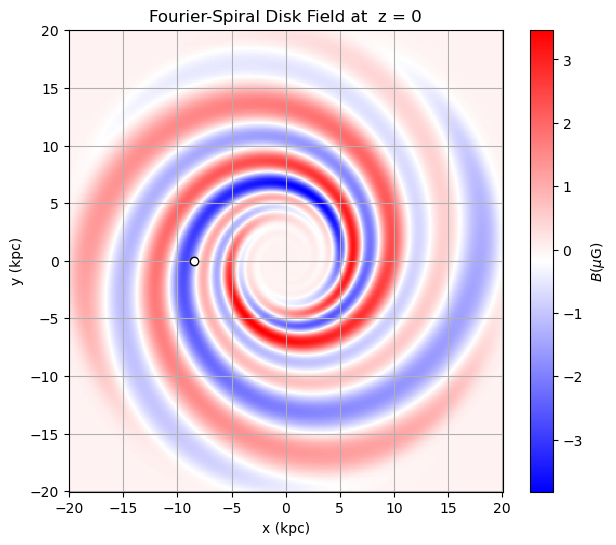

In [8]:
plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk, cmap = plt.cm.bwr, shading='auto')

plt.colorbar(p, label = '$B (\mu\mathrm{G})$')
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('Fourier-Spiral Disk Field at  z = 0')

plt.plot(-8.5, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()

# Spiral Spur disk field

Paramters for spur model

In [9]:
fDiskB1        = -4.2993328e+00 * microgauss
fDiskH         =  7.5019749e-01 * kpc
fDiskPhase1    =  1.5589875e+02 * degree
fDiskPitch     =  1.2074432e+01 * degree
fDiskW         =  1.2263120e-01 * kpc
fPoloidalB     =  9.9302987e-01 * microgauss
fPoloidalP     =  1.3982374e+00 * kpc
fPoloidalR     =  7.1973387e+00 * kpc
fPoloidalW     =  1.2262244e-01 * kpc
fPoloidalZ     =  4.4853270e+00 * kpc
fSpurCenter    =  1.5718686e+02 * degree
fSpurLength    =  3.1839577e+01 * degree
fSpurWidth     =  1.0318114e+01 * degree
fStriation     =  3.3022369e-01
fToroidalBN    =  2.9286724e+00 * microgauss
fToroidalBS    = -2.5979895e+00 * microgauss
fToroidalR     =  9.7536425e+00 * kpc
fToroidalW     =  1.4210055e+00 * kpc
fToroidalZ     =  6.0941229e+00 * kpc

fSinPitch = np.sin(fDiskPitch)
fCosPitch = np.cos(fDiskPitch)
fTanPitch = np.tan(fDiskPitch)

In [10]:
def get_spur_field_cyl(rho, phi, z):

    if (not rho.shape[0] == phi.shape[0]) or (not z.shape[0] == phi.shape[0]):
        raise ValueError("List do not have equal shape!")

    rho = np.where(rho == 0, 1e-12 * kpc, rho)
    
    # Adjust phi values
    phi = np.where(phi < 0, phi + kTwoPi, phi)

    # reference approximately at solar radius
    phi_ref = fDiskPhase1
    r_ref = 8.2 * kpc

    # Logarithmic spiral comparison
    P = phi - phi_ref + np.array([-1, 0, 1])[:, np.newaxis] * kTwoPi
    R = r_ref * np.exp(P * fTanPitch)
    abs_diff = np.abs(rho - R)
    i_best = np.argmin(abs_diff, axis=0)

    has_spur = i_best == 1

    # Eq. 12
    phi0 = phi - np.log(rho / r_ref) / fTanPitch

    # Eq. (16)
    delta_phi0 = delta_phi(phi_ref, phi0)
    delta = delta_phi0 / fSpurWidth
    b = np.where(has_spur, fDiskB1 * np.exp(-0.5 * delta ** 2), 0)

    # Eq. (18)
    w_s = 5 * degree
    phi_c = fSpurCenter
    delta_phi_c = delta_phi(phi_c, phi)
    l_c = fSpurLength
    g_s = 1 - np.where(has_spur, sigmoid(np.abs(delta_phi_c), l_c, w_s), 0)

    # Eq. (13)
    hd = 1 - sigmoid(np.abs(z), fDiskH, fDiskW)

    # Eq. (17)
    b_s = np.where(has_spur, r_ref / rho * b * hd * g_s, 0)

    b_cyl = np.vstack((b_s * fSinPitch, b_s * fCosPitch, np.zeros_like(b_s)))
    b_cyl = np.where(rho==0, np.array([[0], [0], [0]]), b_cyl)
    
    return b_cyl

### Testing

In [11]:
x = np.linspace(-20, 20, 401)
y = np.linspace(-20, 20, 401)
z = np.linspace(-5, 5, 101)

xx,yy,zz = np.meshgrid(x, y, z, indexing='ij')

rr = np.sqrt(xx ** 2. + yy ** 2.) # rho component
pp = np.arctan2(yy, xx) # phi component

idz = np.argmin(np.abs(z))

In [12]:
Bdisk = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    B = get_spur_field_cyl(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk[:,i] = np.sqrt(np.sum(B**2., axis=0))*signum(B[1,:])

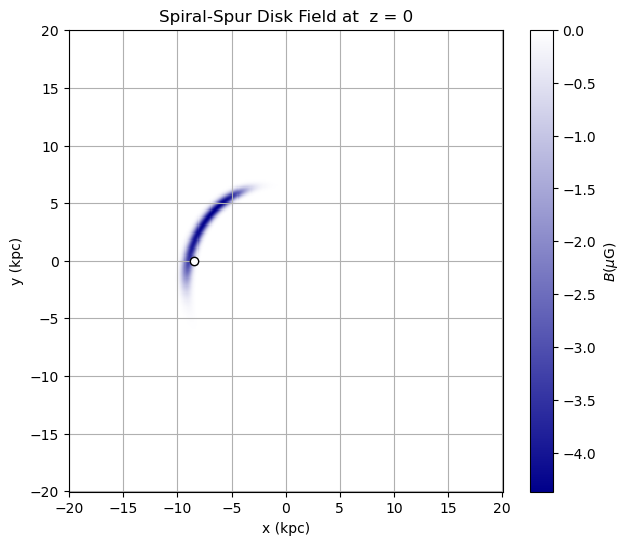

In [13]:
plt.figure(figsize=(7,6))
cmap0 = LinearSegmentedColormap.from_list('', ['darkblue', 'white'])

p = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk, cmap = cmap0, shading='auto')

plt.colorbar(p, label = '$B (\mu\mathrm{G})$')
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('Spiral-Spur Disk Field at  z = 0')

plt.plot(-8.5, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()